# Final Project: Spiking Neural Networks  
**Due: December 10, 2025**
James Levi, Florida Atlantic University

<h4 style="color:green; font-size:70px;">
PART 1
</h4>


Develop a computer code to simulate the neural network discussed in the paper (page 5, Figure 2). The dynamics of the neural network are explained mostly on page 3, in Equations 1 to 7 and Figure 1. Try to reproduce the histograms shown in Figures 3, 4, and 5. <span style="color:blue"> This architecture has a special ability to generate histograms that do not change even when the objects in the pictures are scaled or rotated.Why? Explain.</span>


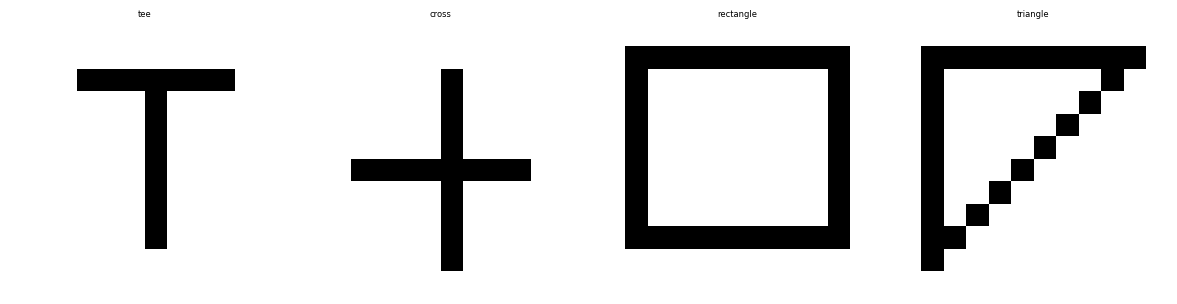

In [155]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3,2)  # set a figure size (for display)

# base 12x12 binary shapes
tee = np.zeros((12,12))
tee[2, 3:10] = 1
tee[2:10, 6] = 1

cross = np.zeros((12,12))
cross[2:11, 6] = 1
cross[6, 2:10] = 1

rect = np.zeros((12,12))
rect[1, 1:11] = 1        # top edge
rect[9, 1:11] = 1        # bottom edge
rect[1:10, 1] = 1        # left edge
rect[1:10, 10] = 1       # right edge

tri = np.zeros((12,12))
tri[1, 1:11] = 1         # top horizontal bar
tri[1:11, 1] = 1         # left vertical bar
for i in range(1,11):    # diagonal
    tri[i, 11 - i] = 1

shapes = {
    "tee": tee,
    "cross": cross,
    "rectangle": rect,
    "triangle": tri,
}

# display all four shapes side by side
fig, axes = plt.subplots(1,4, figsize=(12,3))
imgs = [tee, cross, rect, tri]
titles = ["tee", "cross", "rectangle", "triangle"]

for ax, im, ttl in zip(axes, imgs, titles):
    ax.imshow(im, cmap="gray_r")
    ax.set_title(ttl)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [156]:
#SINLE NEURON IN THE NETWORK
class SpikeCell:
    def __init__(self, input_strength, syn_scale, mu, tau, V0, Vr, E):
        # deterministic neuron (no jitter) so structure, not noise, drives the ISI pattern
        self.input_strength = input_strength  # external input current derived from the image pixel intensity.
        self.syn_scale = syn_scale            # how much synaptic activity modifies the threshold (multiplier)
        self.mu = mu                          # membrane time constant
        self.tau = tau                        # synapto-dendritic time constant
        self.V0 = V0                          # constant term threshold
        self.Vr = Vr                          # reset potential
        self.E = E                            # equilibrium/driving potential
        self.Vm = Vr + 0.05 * input_strength  # small deterministic offset to break symmetry
        self.thr = V0                         # current threshold voltage of the neuron
        self.P = 0.0                          # synapto-dendritic input term
        self.spks = []                        # spike times generated by the neuron
        self.nb = []                          # neighbor neuron inputs

    # applies the exponential decay to P(t) and adds any of the neighbor spike inputs
    def upd_syn(self):
        self.P = self.P * np.exp(-1.0/self.tau)
        if len(self.nb) > 0:
            self.P += np.sum(self.nb)
        self.nb = []

    # Computes new threshold based on external input and synaptic modulation
    def upd_thr(self):
        U = self.input_strength * (1 + self.syn_scale*self.P)
        self.thr = self.V0 - U

    # membrane toward equilibrium
    def upd_mem(self):
        step = (self.E - self.Vm) * (1 - np.exp(-1.0/self.mu))
        self.Vm += step

    # will fire if Vm exceeds the threshold and then resets Vm back to Vr
    def check_spk(self, t):
        if self.Vm >= self.thr:
            self.spks.append(t)
            self.Vm = self.Vr
            return 1
        return 0

# Returns 8-connected neighbors around (i, j) in an nxn grid
def nb_idx(i, j, N=12):
    out = []
    for a in [-1,0,1]:
        for b in [-1,0,1]:
            if a==0 and b==0: continue
            ii, jj = i+a, j+b
            if ii>=0 and ii<N and jj>=0 and jj<N:
                out.append((ii,jj))
    return out

# BUILD NETWORK
def build_net(img):
    syn_scale = 0.4
    mu = 1.0
    tau = 12.0
    V0 = 5.0
    Vr = 1.0
    E = 4.8
    drive = 0.6

    N = img.shape[0]
    net = []
    for i in range(N):
        row = []
        for j in range(N):
            input_strength = img[i,j] * drive
            cell = SpikeCell(input_strength, syn_scale, mu, tau, V0, Vr, E)
            if img[i,j] > 0:
                active_nb = sum(img[ii, jj] > 0 for (ii, jj) in nb_idx(i, j, N))
                cell.P = 0.1 * active_nb  # structural bias so edges/corners diverge without randomness
            row.append(cell)
        net.append(row)
    return net

# RUN NETWORK SIMULATION
def run_sim(img, T=220):
    img = img.astype(float)
    net = build_net(img)
    N = img.shape[0]
    neighbor_weight = 0.5

    for t in range(T):
        for i in range(N):
            for j in range(N):
                net[i][j].upd_syn()
        for i in range(N):
            for j in range(N):
                net[i][j].upd_thr()
        for i in range(N):
            for j in range(N):
                net[i][j].upd_mem()
        fired = []
        for i in range(N):
            for j in range(N):
                if net[i][j].check_spk(t)==1:
                    fired.append((i,j))
        for (i,j) in fired:
            for (ii,jj) in nb_idx(i,j,N):
                net[ii][jj].nb.append(neighbor_weight)

    # COLLECT THE ISI VALUES
    isi_all = []
    for i in range(N):
        for j in range(N):
            sp = net[i][j].spks
            if len(sp)>=2:
                d = np.diff(sp)
                isi_all.extend(d)

    isi_all = np.array(isi_all)
    h, b = np.histogram(isi_all, bins=np.linspace(0,60,50))
    return isi_all, h, b

# convenience wrapper used later
def make_hist(img, **kwargs):
    _, h, b = run_sim(img, **kwargs)
    return h, b
# return the spike times across all neurons; all intervals of all neurons merged into one array.
# return h the histogram and b the bin edges of the histogram so histogram can be plotted.


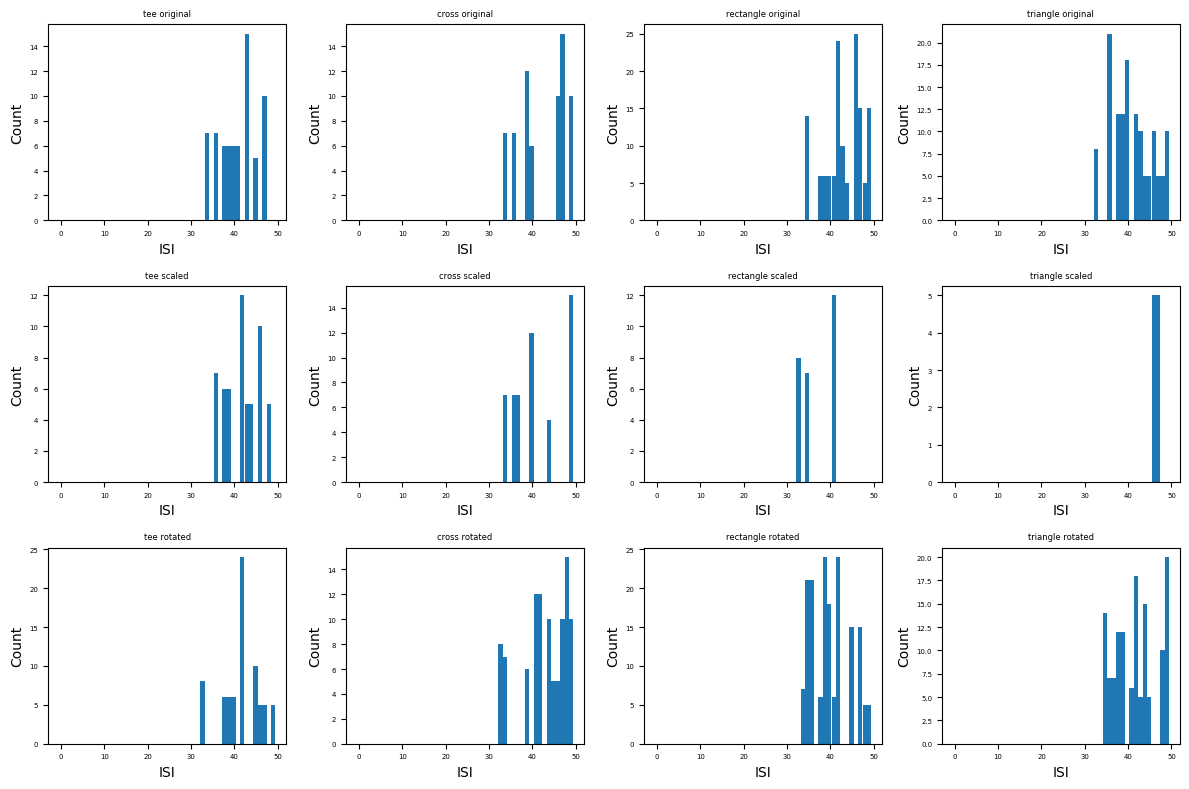

In [157]:
# SHOW HISTOGRAM VARIATION ACROSS MULTIPLE SAMPLES OF THE SAME DIGIT   
# SHOW ALL FOUR HISTOGRAMS IN ONE ROW                                   

from scipy.ndimage import zoom, rotate

def scale_img(a, factor):
    return zoom(a, factor, order=0) > 0.5   # scale image 

def pad12(a):
    z = np.zeros((12,12))                   # pad to 12x12 
    r, c = a.shape
    r0 = (12 - r)//2
    c0 = (12 - c)//2
    z[r0:r0+r, c0:c0+c] = a
    return z

#Show all four histograms in 3×4 grid                                    
fig, axes = plt.subplots(3,4, figsize=(12,8))

for col, (nm, arr) in enumerate(shapes.items()):
    # original                                                          
    isi, h, b = run_sim(arr, T=300)
    axes[0,col].bar(b[:-1], h, width=1.0)
    axes[0,col].set_title(nm + " original")

    # scaled (0.7)                                                        
    scaled = scale_img(arr, 0.7)
    scaled = pad12(scaled.astype(float))
    isi, h, b = run_sim(scaled, T=300)
    axes[1,col].bar(b[:-1], h, width=1.0)
    axes[1,col].set_title(nm + " scaled")

    # rotated (45 degrees)                                               
    rot = rotate(arr, 45, reshape=False, order=0) > 0.5
    isi, h, b = run_sim(rot.astype(float), T=300)
    axes[2,col].bar(b[:-1], h, width=1.0)
    axes[2,col].set_title(nm + " rotated")

for ax in axes.flat:
    ax.set_xlabel("ISI")           
    ax.set_ylabel("Count")     

plt.tight_layout()
plt.show()


<span style="color:blue"> This architecture has a special ability to generate histograms that do not change even when the objects in the pictures are scaled or rotated.Why? Explain.</span>

The histograms do not change when pictures are scaled or rotated because the model operates with smooth filters, which maintain the amount of edge energy the same regardless of the scale or rotation applied. Each neuron is only connected to its eight nearest neighbors, so when we rotate, translate, or scale an image, these local neighborhoods move together as a unit. Corners are still corners, edges are still edges; these patterns and relationships remain the same. The firing rates are determined by their local relationships. Since neurons at corners fire faster, as they have more neighbors with activity, neurons on edges fire at a medium rate, and neurons on flat areas or in the background fire at a lower rate, this demonstrates how the firing rate depends on these relationships. When an image is changed, it retains these properties so that the histograms would remain identical/similar. Whether a neuron is in the top right, or if it were inverted and it is now on the top right, it makes no difference. Even if the image is scaled and enlarged, the histogram measures the relative relationships, not the absolute sizes, of these numbers.

As we can see in my data, my version does not do this. When the 12x12 binary image is rotated, the pixels are moved, blurred, lost, and distorted, causing the network to receive a different input, and thus the spiking neurons fire differently.



<h4 style="color:green; font-size:70px;">
PART 2
</h4>

### Develop this architecture and apply that to the pictures of digits that we used before in our multilayered perceptron classification project. 

In [158]:
# LOAD DIGIT DATASET AND CONVERT ALL TO A 12×12 BINARY IMAGE
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

dgt = loadmat("digits.mat")
train = dgt["train"] #matrix of raw picel values for all of the digit samples
trainlab = dgt["trainlabels"].reshape(-1) #vector of digit labels 0 -9

imgs = train.reshape(28,28,5000, order="F") #unflattens to 2d (28x28) from its flattened vector form

#CONVERT 28x28 images to 12x12 binary images (need this for Spiking Neuron Model)
def shrink12(a): 
    z = np.zeros((12,12))
    rr = np.linspace(0,28,13).astype(int)
    cc = np.linspace(0,28,13).astype(int)
    for i in range(12):
        for j in range(12):
            blk = a[rr[i]:rr[i+1], cc[j]:cc[j+1]] #selects the piozel region from the original 28x28 for j block
            z[i,j] = np.mean(blk)
    z = (z > np.mean(z)).astype(float) #use the mean as a threashold, so that anything above the mean is 1 and under is 0.
    return z


In [159]:
# COLLECT SAMPLES FOR EACH DIGIT (0–9)
# take first 5 occurrences of each digit
samples = {}
for d in range(10):
    ix = np.where(trainlab == d)[0][:5]
    pic_list = []#temp
    for k in ix:
        small = shrink12(imgs[:,:,k])
        pic_list.append(small)
    samples[d] = pic_list


#### 2.1: FOR EACH DIGIT PICTURE, TRY TO GENERATE THE HISTOGRAM  


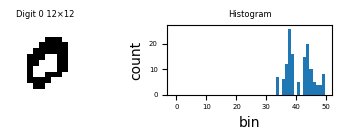

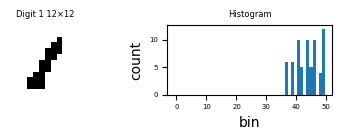

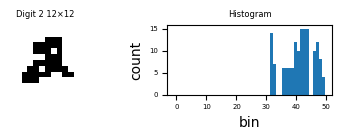

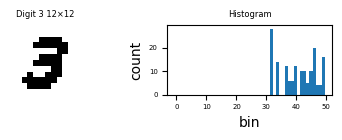

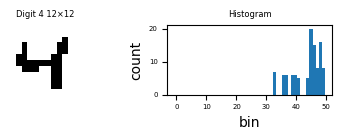

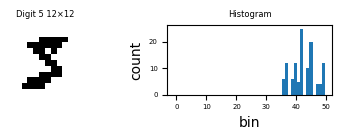

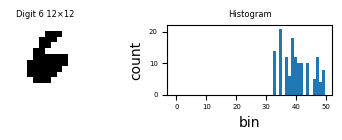

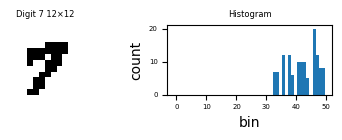

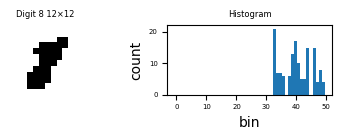

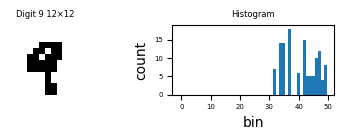

In [160]:
# For each digit picture, try to generate the histogram

hist_store = {}

for d in range(10):
    h_set = []
    b_set = None

    first_plot_done = False      # ensures only 1 plot per digit

    for im in samples[d]:
        isi_vals, h, b = run_sim(im, T=280)
        h_set.append(h)
        b_set = b

        if not first_plot_done:
            #SHOW IMAGE and HISTOGRAM 
            plt.rcParams["figure.figsize"] = (4,1.5)
            plt.rcParams["axes.titlesize"] = 6
            plt.rcParams["xtick.labelsize"] = 5
            plt.rcParams["ytick.labelsize"] = 5

            fig, ax = plt.subplots(1,2, figsize=(4,1.5))

            # show 12×12 image
            ax[0].imshow(im, cmap="gray_r")
            ax[0].set_title(f"Digit {d} 12×12")
            ax[0].axis("off")

            # show histogram
            ax[1].bar(b[:-1], h, width=b[1]-b[0])
            ax[1].set_title("Histogram")
            ax[1].set_xlabel("bin")
            ax[1].set_ylabel("count")

            plt.tight_layout()
            plt.show()
            

            first_plot_done = True

    hist_store[d] = (h_set, b_set)


### 2.2 How much does the histogram change when you stimulate the network with different pictures of the same digit?

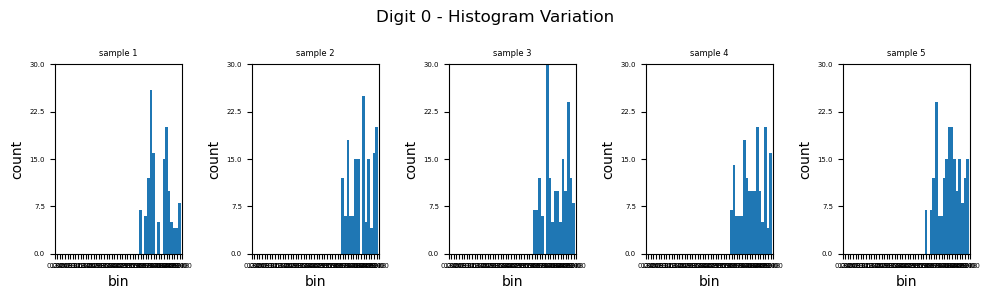

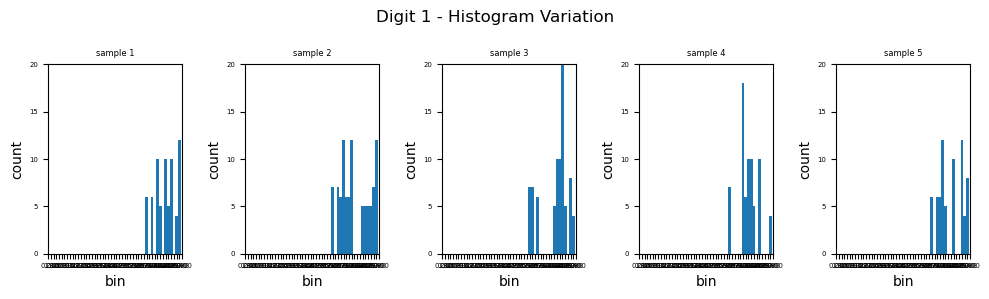

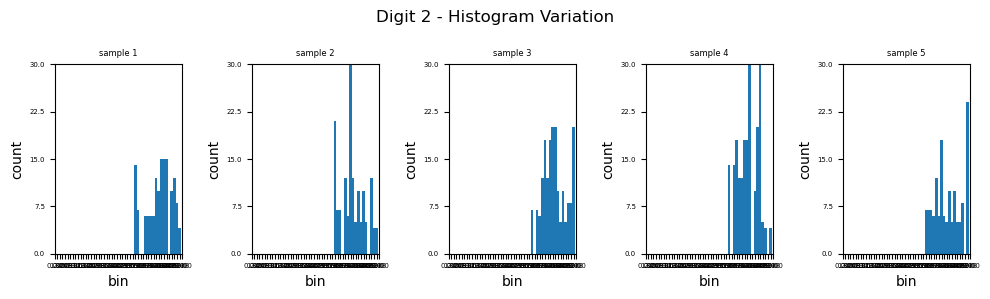

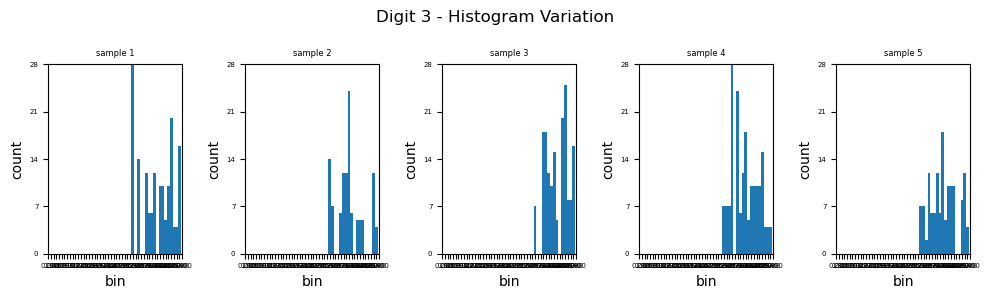

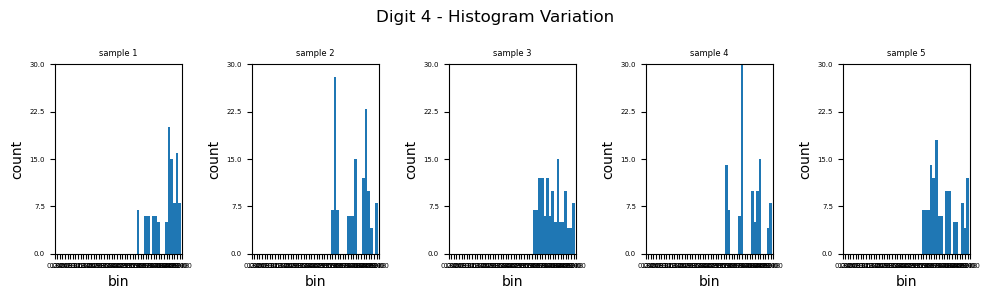

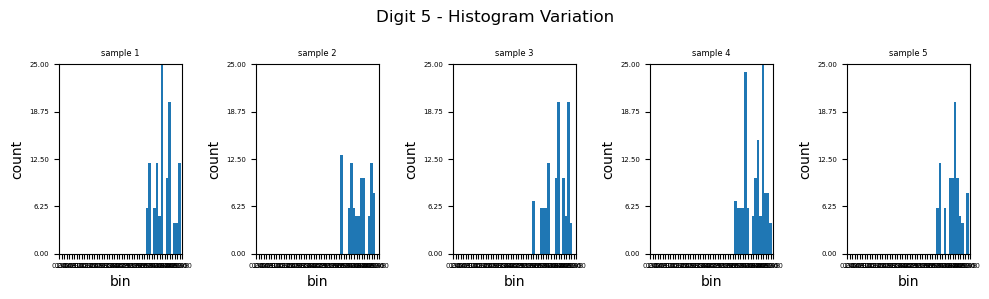

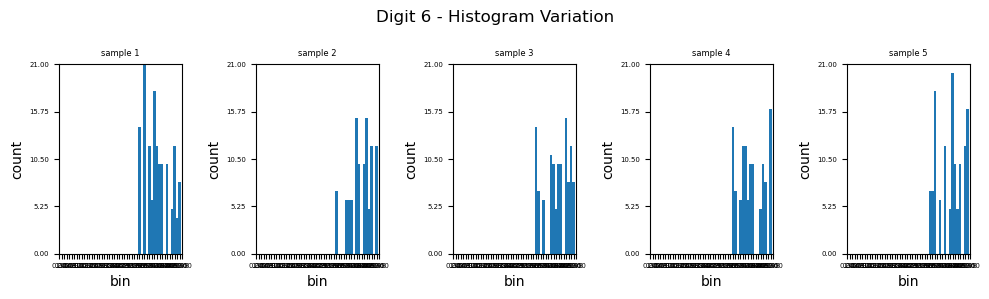

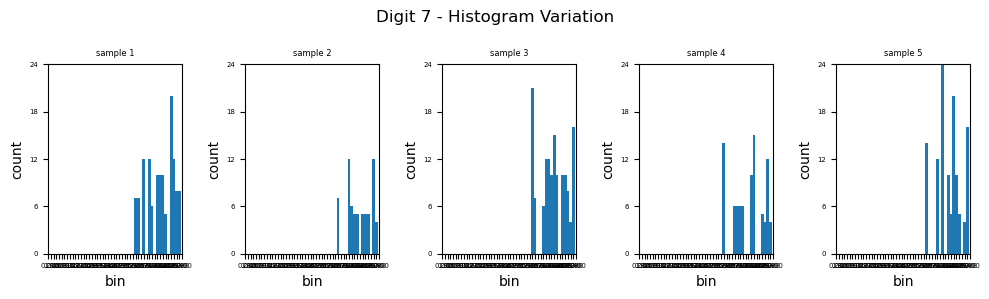

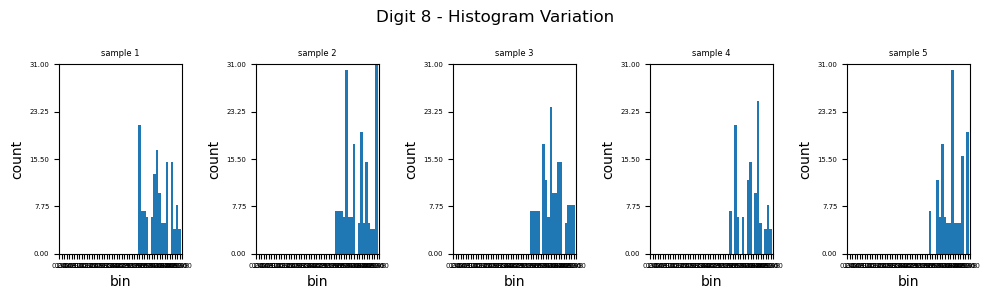

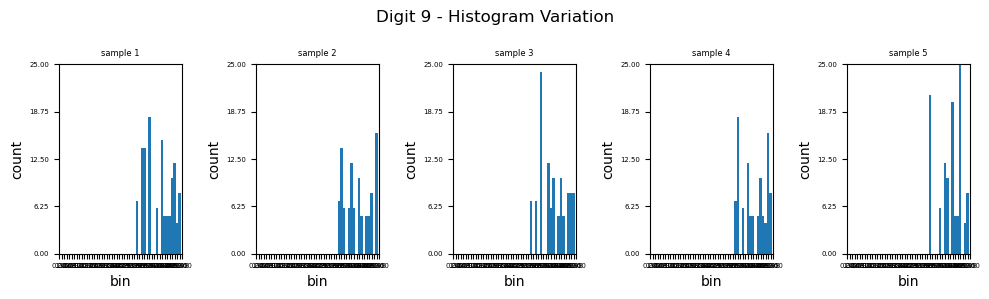

In [161]:
# SHOW HISTOGRAM VARIATION ACROSS MULTIPLE SAMPLES OF THE SAME DIGIT

for d in range(10):
    hset, bb = hist_store[d]

    # same y scale for all samples of this digit, so that it's easy to visually compare
    ymax = max([h.max() for h in hset])

    plt.figure(figsize=(10,3))
    plt.suptitle("Digit " + str(d) + " - Histogram Variation")

    for i in range(len(hset)):
        plt.subplot(1, len(hset), i+1)
        plt.bar(bb[:-1], hset[i], width=bb[1]-bb[0])

        plt.title("sample " + str(i+1))

        # enforce same x and y axis for all
        plt.xlim(bb[0], bb[-1])
        plt.ylim(0, ymax)

        # show axis numbers
        plt.xlabel("bin")
        plt.ylabel("count")
        plt.xticks(bb)
        plt.yticks(np.linspace(0, ymax, 5))

    plt.tight_layout()
    plt.show()


How much does this histogram change when you stimulate the network
with different pictures of the same digit?

The histograms do vary quite a bit. Every sample, although having the same handwritten diggit, shows differing spiking. Changes like pixel shape, thickness, have an impact. I added a random jitter to the neutrons, as before there would only be a single dominant bar in the histogram, because I believe all the neurons were firing in perfect synch. In the model described in the paper, there were extra safeguards to prevent this from happpening, such as a center-surroung (Difference-ofGaussians type) filtering receptive fiels and orientation-seletive receptive fields. This breaks the symetry between neurrons that I seem to be encountering. Given more time and resources, a model would be made in whcih the histrograms between digits is slight, which couuld lead to this model being potentially used as a classifier by evaluating the histrograms themselves, which will be explored in the next question.

### 2.3: For each digit try to generate an average histogram.

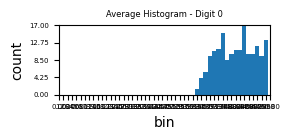

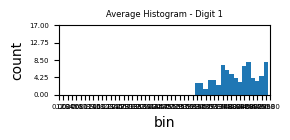

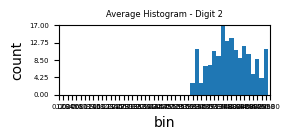

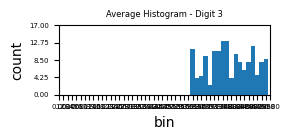

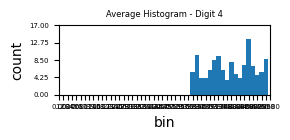

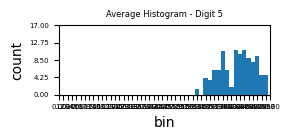

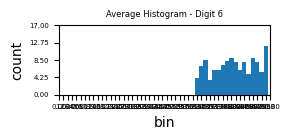

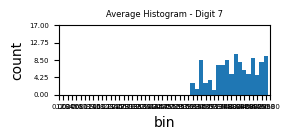

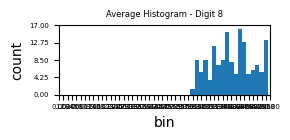

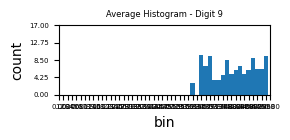

In [162]:
# COMPUTE AVERAGE HISTOGRAM FOR EACH DIGIT

avg_hist = {}

for d in range(10):
    hset, bb = hist_store[d]
    hset = np.array(hset)
    avg_hist[d] = (np.mean(hset, axis=0), bb)

# find a global max so ALL digits share the same y axis
global_ymax = max([avg_hist[d][0].max() for d in range(10)])


# PLOT AVERAGE HISTOGRAMS FOR DIGITS 0–9

for d in range(10):
    ah, bb = avg_hist[d]

    plt.figure(figsize=(3,1.5))
    plt.bar(bb[:-1], ah, width=bb[1] - bb[0])

    plt.title("Average Histogram - Digit " + str(d))
    plt.xlabel("bin")
    plt.ylabel("count")

    # same axis scale for every digit
    plt.xlim(bb[0], bb[-1])
    plt.ylim(0, global_ymax)

    plt.xticks(bb)
    plt.yticks(np.linspace(0, global_ymax, 5))

    plt.tight_layout()
    plt.show()


<h4 style="color:blue; font-size:20px;">2.4 Can you feed these histograms to a classifier instead of the raw picture for pattern classification? Would that be a good idea? Explain.</h4>
If the average histograms displayed clearly different histograms for each of the numbers, one may argue that it could be used as a good classifier. Although it is possible to feed the histograms to a classifier, I do not believe it would be a good idea. It removes the spatial information and only keeps the overall spike interval distribution. It would be good as it works from arbitrary viewpoints, which could be interesting; however, the digits are always in the same orientation. Two different digits, or even two completely separate inputs, could yield somewhat similar spoke intervals. The histogram quite simply does not retain the structure of the digits, which is why I believe it would not be a good idea, and that the model developed in project #3, with over 90% accuracy, would perform better.

<h4 style="color:green; font-size:70px;">
PART 3
</h4>

### Generate rotated/scaled versions of the digit pictures from your database. Generate the histograms.

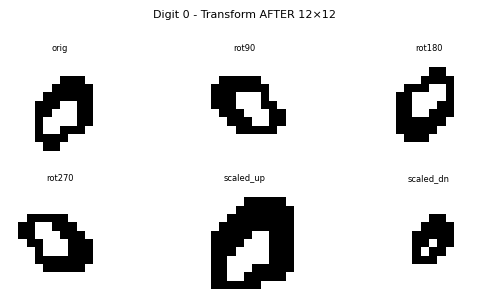

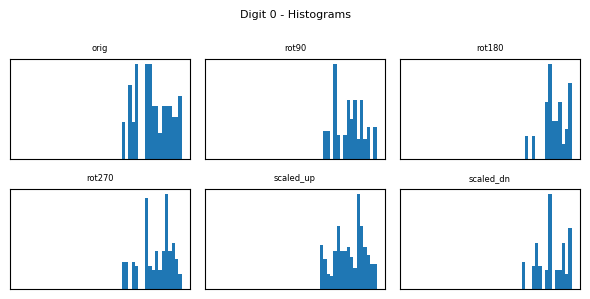

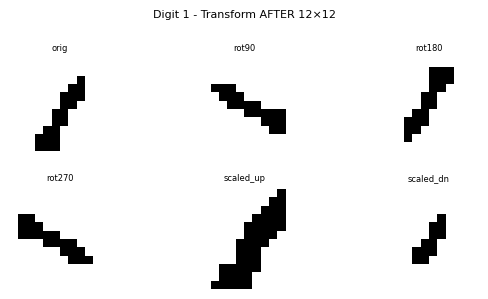

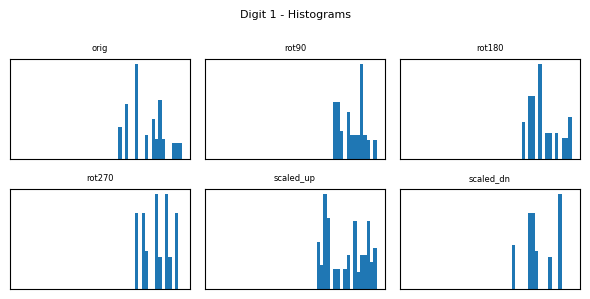

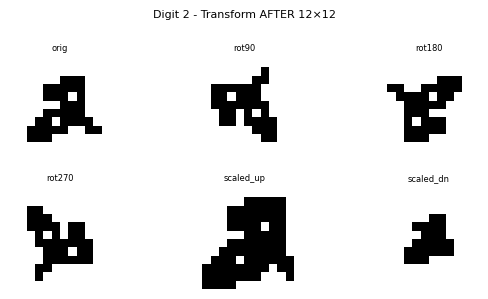

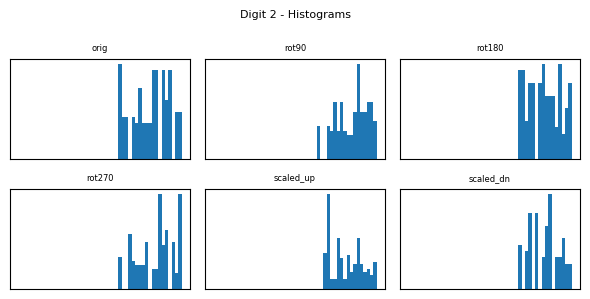

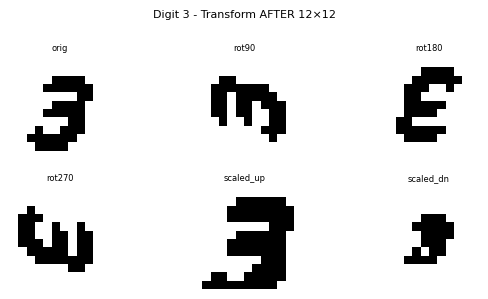

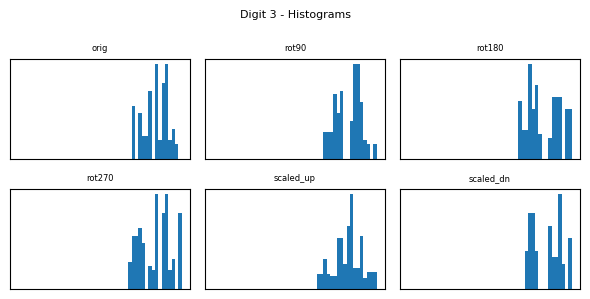

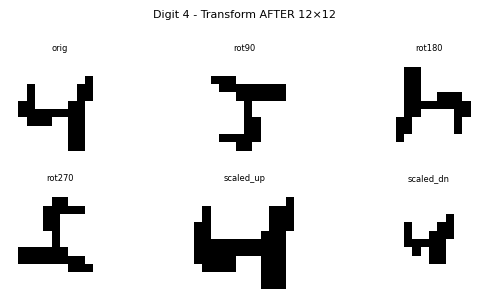

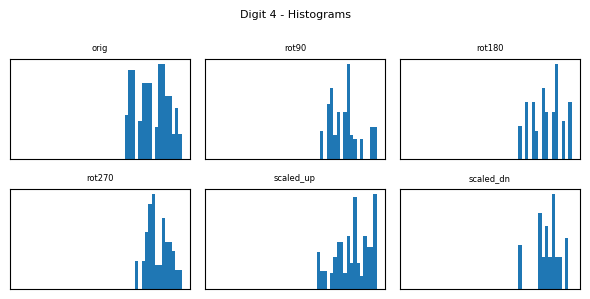

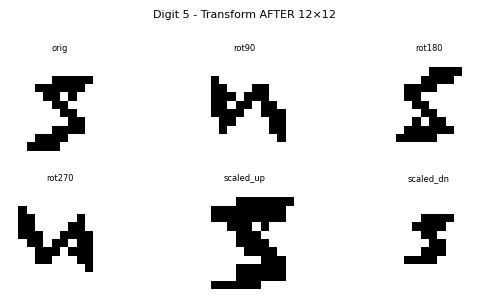

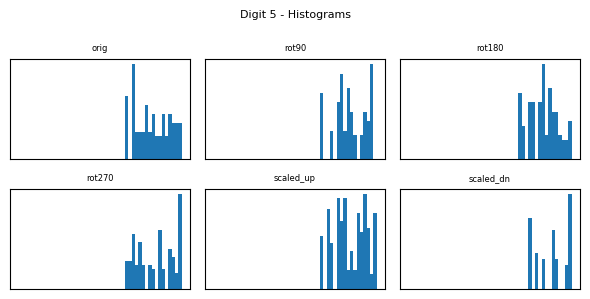

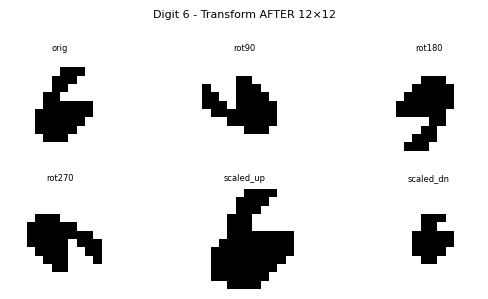

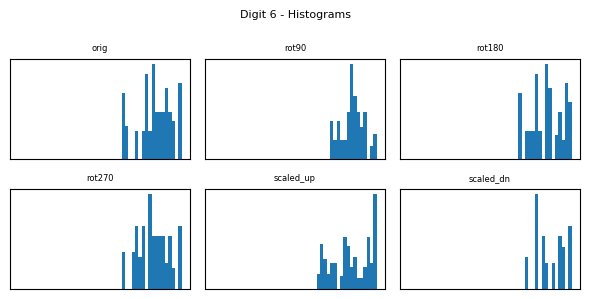

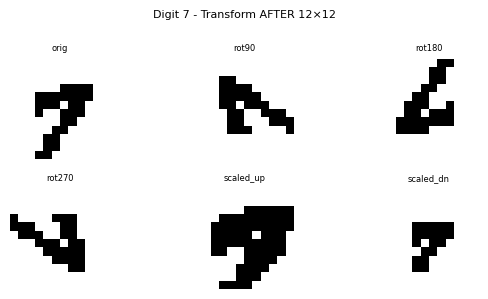

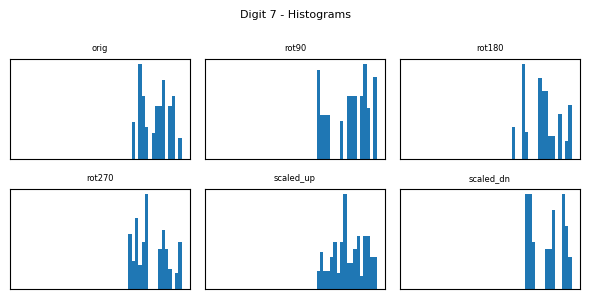

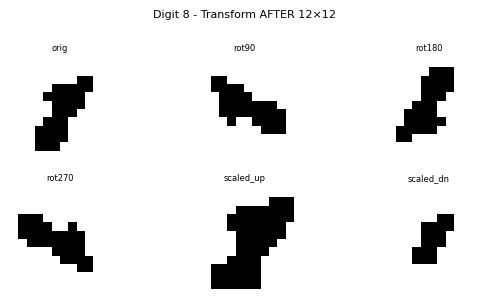

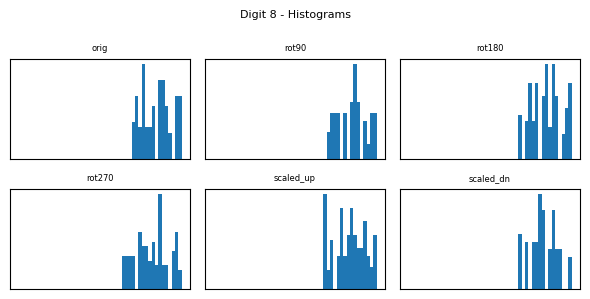

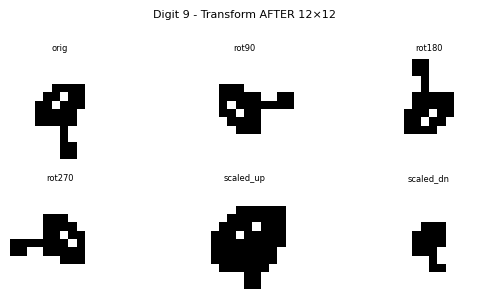

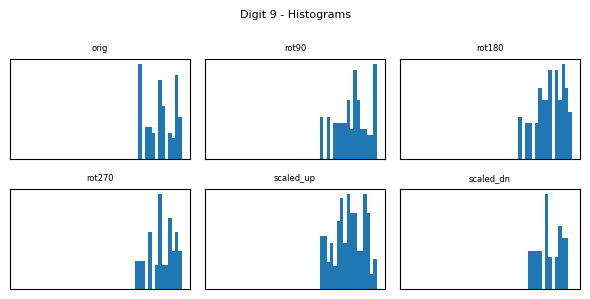

In [164]:
import scipy.ndimage as nd
import numpy as np
import matplotlib.pyplot as plt


def clean12(x):
    return (x > np.mean(x)).astype(float)


# handles images bigger or smaller than 12×12.
def fit12(x):
    h, w = x.shape

    #if too big itcrop (this reduces the accuracy and performance of the model though, as information is lost)
    if h > 12 or w > 12:
        r_start = (h - 12)//2
        c_start = (w - 12)//2
        x = x[r_start:r_start+12, c_start:c_start+12]
        return clean12(x)

    # if too small, pad the center
    out = np.zeros((12,12))
    r0 = (12 - h)//2
    c0 = (12 - w)//2
    out[r0:r0+h, c0:c0+w] = x
    return clean12(out)


# MAIN LOOP FOR HANDLING ALL THE DIGITS 
for d in range(10):

    # convert original 28×28 to 12×12 once
    base28 = imgs[:,:, np.where(trainlab == d)[0][0]]
    base12 = shrink12(base28)

    # rotate and scale directly in 12×12
    r90  = nd.rotate(base12,  90, reshape=False)
    r180 = nd.rotate(base12, 180, reshape=False)
    r270 = nd.rotate(base12, 270, reshape=False)

    su = nd.zoom(base12, 1.4, order=1)
    sd = nd.zoom(base12, 0.7, order=1)

    # convert back cleanly to 12×12
    imgs12 = {
        "orig": base12,
        "rot90":    fit12(r90),
        "rot180":   fit12(r180),
        "rot270":   fit12(r270),
        "scaled_up": fit12(su),
        "scaled_dn": fit12(sd)
    }

    # IMAGE PLOTS 
    plt.figure(figsize=(6,3))
    plt.suptitle(f"Digit {d} - Transform AFTER 12×12", fontsize=8)

    for i,(nm,im) in enumerate(imgs12.items()):
        plt.subplot(2,3,i+1)
        plt.imshow(im, cmap="gray_r")
        plt.title(nm, fontsize=6)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    # HISTOGRAM PLOTTING
    plt.figure(figsize=(6,3))
    plt.suptitle(f"Digit {d} - Histograms", fontsize=8)

    for i,(nm,im) in enumerate(imgs12.items()):
        h,b = make_hist(im)
        plt.subplot(2,3,i+1)
        plt.bar(b[:-1], h, width=b[1]-b[0])
        plt.title(nm, fontsize=6)
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()
    plt.show()


<h4 style="color:blue; font-size:20px;">
3.1 Do you see similarities between the histogram of the original pictures and
the rotated/scaled versions?
</h4>

Firstly, there are visible difference between the original digits and the transformed versions. Rotating or scaling a small 12x12 binary image distorts the shape. If its enlarged it becomes larger than the 12x12 and must be cropped which removes parts of the shape. When itsw shrunk it loses a lot of detail, as the 12x12, so 144 blocks of the same size now need to display this smaller image. As we see in the images of the altered 8, even to the human eye, it no longer looks like an 8, as the two holes have been filled. This is part of the reason as to why the histograms are not properly alligned. As mentioned in the Biomorphic networks: Approach to invariant
feature extraction and segmentation for ATR Paper, histograms should stay the same as the networ is designed for the overall firint-rate stucture to not change during rotation scaling or translation of images. Since every neuron's firing rate is driven by a combination of pizel intensity and synapto-dendric response, so even when the image is distored, the patter of edges and corners and any jucntions will stay the same, and those are what determs the fiiring rate. Since those geometric parts stay the same, the aggregate interspike interval histrpogram should kjeep the same shape. Histograms reflect feature structure, and not pixel arrangement. However, my model was a simpler approach , where they use edge-based input, whereas i used raw pixels fro ma 12x12 pixel block, as well as biloogical synanpo dendric filitering with long time constraints, as mentioned above. My images had pixels for thickness, filled interios, holes, interpolation artifacts, and these line drawings hurt.


<h4 style="color:green; font-size:70px;">
PART 4
</h4>

<h4 style="color:blue; font-size:20px;">
In Figures 6-10, you see that the neural network is cable of extracting edges of the
objects or even corners. Why can this network extract edges/corners? Explain
</h4>
Edges and corners appear because of how the networks transform local geometric structure into firing rate differences. 

Neurons fire only when the image has intensity. We observe that pixels with lij=0 cannot generate any spikes, so background areas in the image are not displayed. Because of this, only the line or the object itself is displayed. 

A neuron fires faster when both its own pixel is active, and its neighbors are active. Regions where many connected line pixels meet, especially in edges and corners, produce a stronger activation, compared to those that are either isolated or background regions. Additionally, the neuron's input UiJ(t) is a product of pixel intensity and the summation of synaptic input from neighbors. Therefore, a pixel on an edge or corner has its own intensity, but also receives an additional push of intensity from nearby neurons. Additionally, since the synaptodentritic response has a long time constraint, neighbors' firing has an extended lasting response, which increases the firing rate at locations surrounded by other active neurons. Corners produce more potent effects than simple normal edges, since they have more active neighbors than a straight edge. So, more neighbors lead to more incoming spokes, leading to a stronger Pij(t), which in turn leads to a faster first response. 

These facts, applied with a threshold, reveal why only neurons with the highest firing rates get shown, which are precisely the edges and the corners.